This script generates the 3D flow figure to show the simulation setup.

Todo: move the drone profile generation function to utility

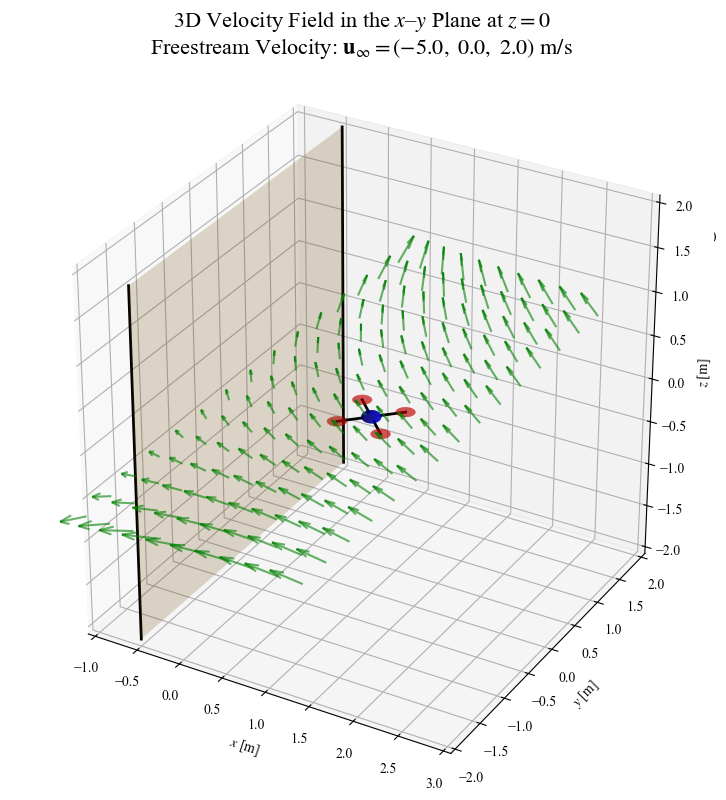

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import flow_pass_flat_plate

def generate_drone_profile_with_solid_geometry(position: np.ndarray, pose: np.ndarray,
                                                disk_radius=0.1, ball_radius=0.1,
                                                arm_length=0.25, resolution=40):
    rotor_offsets = [
        arm_length * (pose[:, 0] + pose[:, 1]),
        arm_length * (-pose[:, 0] + pose[:, 1]),
        arm_length * (-pose[:, 0] - pose[:, 1]),
        arm_length * (pose[:, 0] - pose[:, 1])
    ]
    arms = []
    disk_surfaces = []

    r = np.linspace(0, disk_radius, resolution)
    theta = np.linspace(0, 2 * np.pi, resolution)
    r, theta = np.meshgrid(r, theta)
    circle_x = r * np.cos(theta)
    circle_y = r * np.sin(theta)

    for offset in rotor_offsets:
        direction = offset / np.linalg.norm(offset)
        hub_center = position + offset
        sphere_exit = position + direction * ball_radius

        disk_points = (pose[:, 0][:, None, None] * circle_x +
                       pose[:, 1][:, None, None] * circle_y +
                       hub_center[:, None, None])
        X, Y, Z = disk_points[0], disk_points[1], disk_points[2]
        disk_surfaces.append((X, Y, Z))

        arms.append(np.vstack((sphere_exit, hub_center)))

    # Sphere surface
    u, v = np.meshgrid(np.linspace(0, 2 * np.pi, resolution),
                       np.linspace(0, np.pi, resolution))
    sx = ball_radius * np.cos(u) * np.sin(v) + position[0]
    sy = ball_radius * np.sin(u) * np.sin(v) + position[1]
    sz = ball_radius * np.cos(v)*0.5 + position[2]

    return disk_surfaces, (sx, sy, sz), arms

def generate_wall_surface(origin, normal, length, resolution=2):
    """
    Generate a square wall centered at 'origin' with normal 'normal'.
    Returns X, Y, Z grids for surface plotting.
    """
    normal = normal / np.linalg.norm(normal)
    # Find two orthogonal in-plane vectors
    if np.allclose(normal, [1, 0, 0]):
        tangent1 = np.array([0, 1, 0])
    else:
        tangent1 = np.cross(normal, [1, 0, 0])
        tangent1 = tangent1 / np.linalg.norm(tangent1)
    tangent2 = np.cross(normal, tangent1)

    grid = np.linspace(-length/2, length/2, resolution)
    u, v = np.meshgrid(grid, grid)
    points = (origin[:, None, None] +
              tangent1[:, None, None] * u +
              tangent2[:, None, None] * v)
    return points[0], points[1], points[2]

def set_axes_equal(ax):
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    center = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    for c, set_lim in zip(center, [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d]):
        set_lim([c - radius, c + radius])


# === Flow field setup ===
wall_norm = np.array([1.0, 0.0, 0.0])   # facing x-axis
wall_inifinity = np.array([0.0, 0.0, 1.0])
wall_origin = np.array([-0.5, 0.0, 0.0])
wall_length = 8.0    
flow = flow_pass_flat_plate.FlowPassFlatPlate.Interface(wall_norm, wall_inifinity, wall_origin, wall_length)
u_free=np.array([-5.0, 0.0, 2.0])
velocity_at_one_point = flow.get_solution(u_free, np.array([1.0, 1.0, 1.0]))

# === Main plot ===
position = np.array([1.0, 0.0, 0.0])
pose = np.eye(3)  # standard axes

disk_surfaces, (sx, sy, sz), arms = generate_drone_profile_with_solid_geometry(position, pose)

# Wall parameters
wall_origin = np.array([-0.5, 0, 0])
wall_norm = np.array([1, 0, 0])
wall_length = 4.0
wx, wy, wz = generate_wall_surface(wall_origin, wall_norm, wall_length)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["mathtext.fontset"] = "stix"

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle(
    r"3D Velocity Field in the $x$–$y$ Plane at $z = 0$" "\n"
    r"Freestream Velocity: $\mathbf{u}_\infty = (-5.0,\ 0.0,\ 2.0)\ \mathrm{m/s}$",
    fontsize=16
)


ax = fig.add_subplot(111, projection='3d')



# Plot drone disks
for X, Y, Z in disk_surfaces:
    ax.plot_surface(X, Y, Z, color='red', alpha=1)

# Plot body sphere
ax.plot_surface(sx, sy, sz, color='blue', alpha=1)

# Plot arms
for arm in arms:
    ax.plot(arm[:, 0], arm[:, 1], arm[:, 2], 'k-', linewidth=2)

# Plot wall
ax.plot_surface(wx, wy, wz, color='orange', alpha=0.2)
# Plot vertical edges of the wall
# Extract vertical edge points from wall surface mesh
corner_bottom_left  = [wx[0, 0], wy[0, 0], wz[0, 0]]
corner_top_left     = [wx[-1, 0], wy[-1, 0], wz[-1, 0]]
corner_bottom_right = [wx[0, -1], wy[0, -1], wz[0, -1]]
corner_top_right    = [wx[-1, -1], wy[-1, -1], wz[-1, -1]]

# Draw left vertical edge
ax.plot(
    [corner_bottom_left[0], corner_top_left[0]],
    [corner_bottom_left[1], corner_top_left[1]],
    [corner_bottom_left[2], corner_top_left[2]],
    color='black', linewidth=2
)

# Draw right vertical edge
ax.plot(
    [corner_bottom_right[0], corner_top_right[0]],
    [corner_bottom_right[1], corner_top_right[1]],
    [corner_bottom_right[2], corner_top_right[2]],
    color='black', linewidth=2
)

# === 3D flow field on x-z plane at y = 0 ===
x_range = np.linspace(-0.4, 2, 10)
y_range = np.linspace(-3, 3, 15)
z_range = np.linspace(-2, 2, 2)
X, Y = np.meshgrid(x_range, y_range)
Z = np.zeros_like(X)

U = np.zeros_like(X)
V = np.zeros_like(X)
W = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pt = np.array([X[i, j], Y[i, j], Z[i, j]])  # y=0 plane
        vel = flow.get_solution(u_free, pt, is_wind_constant_direction_set=True)
        U[i, j] = vel[0]
        V[i, j] = vel[1]  # ignored in quiver since we're plotting in x-z
        W[i, j] = vel[2]

# Use 3D quiver to draw flow vectors
ax.quiver(X, Y, Z, U, V, W,
          length=0.07,
          normalize=False,
          arrow_length_ratio=0.4,   # ← default is 0.3
          color='green',
          alpha=0.6)

# Adjust appearance
set_axes_equal(ax)
ax.set_box_aspect([1, 1, 1])
plt.tight_layout()
ax.set_xlim([-1, 3])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
ax.set_xlabel(r"$x$ [m]")
ax.set_ylabel(r"$y$ [m]")
ax.set_zlabel(r"$z$ [m]")
plt.show()
fig.savefig("flow_field_3d.pdf", dpi=300, bbox_inches='tight')

